In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from mcts import mcts
from mcts import firstActionPolicy
from mcts import randomPolicy
from simulator import farmcell
from bruteforce import bruteforce

import numpy as np
import matplotlib.pyplot as plt
from time import time

In [22]:
# Re-initialize everything
n = 4
farm = np.zeros((n, n), dtype=int)
initialState = farmcell((0, 0), farm)

# Uncomment this for initializing the agent with the initial state, this will keep
# the built tree across searches i.e., the performance may improve (?) as we run more epochs.
# agent = mcts(timeLimit=1000, rolloutPolicy=randomPolicy, initialState=initialState)

# If instead, we want to discard the tree after search and start new with next search, pass
# the initialState to search method as a parameter instead and uncomment this line.
agent = mcts(timeLimit=1000, rolloutPolicy=randomPolicy)

rewards = []
full_tree_over_time = []

In [23]:
epochs = 100
best_farm = None
best_reward = 0
for i in range(epochs):
    # For keeping the tree across searches
    # bestAction = agent.search()
    
    # For rebuilding the tree with each search.
    bestAction = agent.search(initialState=initialState)
    
    last_state, full_tree = agent.optimal_rollout()
    full_tree_over_time.append(1 if full_tree else 0)
    reward = last_state.state.getReward()
    rewards.append(reward)
    if reward > best_reward:
        best_reward = reward
        best_farm = last_state.state.farm

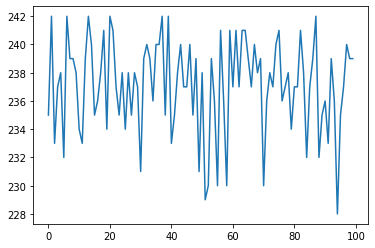

In [24]:
plt.plot(rewards)

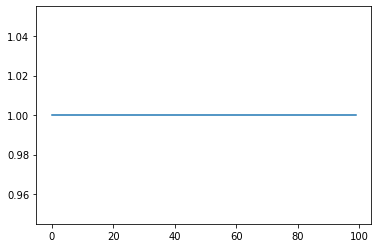

In [25]:
plt.plot(full_tree_over_time)

In [26]:
print (best_reward)
print (best_farm)

242
[[1 1 1 1]
 [1 2 1 2]
 [1 2 1 1]
 [1 1 1 2]]


In [16]:
# Try the brute force way (for small n) to compare against
def find_optimal_by_brute_force(farm_size):
    b = bruteforce(farm_size)
    start = time()
    best_reward, best_farm, total_inputs = b.solve()
    end = time()

    print ('best farm:')
    print (best_farm)
    print ('best_reward: {}'.format(best_reward))
    print ('total number of configurations need to be tested: {}'.format(total_inputs))
    print ('total time taken: {}'.format(end-start))

In [17]:
# find_optimal_by_brute_force(3)

best farm:
[[1 1 1]
 [1 2 1]
 [1 1 1]]
best_reward: 138
total number of configurations need to be tested: 512
total time taken: 0.13996005058288574


In [18]:
# find_optimal_by_brute_force(4)

best farm:
[[1 1 1 1]
 [1 2 1 2]
 [1 2 1 1]
 [1 1 1 2]]
best_reward: 242
total number of configurations need to be tested: 65536
total time taken: 32.295884132385254


In [ ]:
# find_optimal_by_brute_force(5) # This is expected to take more than 4 hours to run!!!